# Evaluation of multi-omics GRN inference methods
## Preprocessing multi-omics data
### by Jalil Nourisa

# Imports 

In [ ]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.cluster import KMeans

import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
import seaborn as sns
import json
import anndata as ad
import warnings
import decoupler as dc

from venn import venn 

work_dir = '../../output'
kaggle_data_dir = '../input/kaggle/input'

In [3]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

# scRNA-seq
We use provided normalized values as X and store the counts in the layers.

### <a id='toc4_1_1_'></a>[Formatize the data](#toc0_)

In [4]:
from scipy.sparse import csr_matrix
import anndata

genes_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Gene Expression']['location'].values
df_mrna = multiome_train[multiome_train['location'].isin(genes_locations)].reset_index(drop=True)
# get count and normalized count
df_mrna_pivot_raw = df_mrna.pivot(index='obs_id', columns='location', values='count')
df_mrna_pivot_raw = df_mrna_pivot_raw.fillna(0)
mrna_sparse_raw = csr_matrix(df_mrna_pivot_raw.values)
df_mrna_pivot_n = df_mrna.pivot(index='obs_id', columns='location', values='normalized_count')
df_mrna_pivot_n = df_mrna_pivot_n.fillna(0)
mrna_sparse_n = csr_matrix(df_mrna_pivot_n.values)

In [ ]:
adata = anndata.AnnData(X=mrna_sparse_n, 
                obs=multiome_obs_meta.set_index('obs_id'),
                var=pd.DataFrame(index=df_mrna_pivot_raw.columns),
                layers={'counts':mrna_sparse_raw}
                )
adata.shape

In [ ]:
adata.write(f'{work_dir}/scRNA/adata_rna.h5ad')

### Cell numbers for different cell types

In [4]:
adata_rna = ad.read(f'{work_dir}/scRNA/adata_rna.h5ad')

In [ ]:
adata_rna.layers['x_norm'] = adata_rna.X

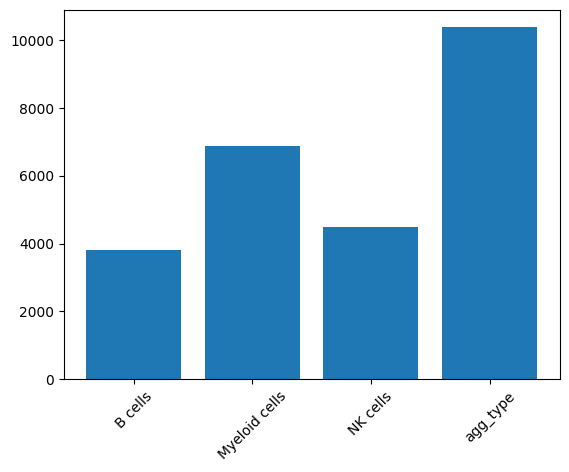

In [5]:
celltype_cellcounts = adata_rna.obs.groupby('cell_type').size()
aa = plt.bar(celltype_cellcounts.index, celltype_cellcounts.values)
aa = plt.xticks(rotation=45)

### Basic steps

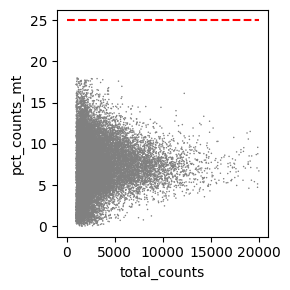

In [ ]:
adata_rna.X = adata_rna.layers['counts']
adata_rna.var['mt'] = adata_rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
import matplotlib.pyplot as plt
mito_filter = 25
fig, axs = plt.subplots(ncols = 1, figsize = (3,3))
sc.pl.scatter(adata_rna, x='total_counts', y='pct_counts_mt', ax = axs, show=False)
#draw horizontal red lines indicating thresholds.
axs.hlines(y = mito_filter, xmin = 0, xmax = max(adata_rna.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

In [ ]:
adata_rna = adata_rna[adata_rna.obs.pct_counts_mt < mito_filter, :]
adata_rna

In [ ]:
import warnings
adata_rna.X = adata_rna.layers['x_norm']
with warnings.catch_warnings():
    sc.pp.filter_cells(adata_rna, min_genes=200)
    sc.pp.filter_genes(adata_rna, min_cells=3)
    warnings.simplefilter("ignore")
    sc.tl.pca(adata_rna, svd_solver='arpack', use_highly_variable=False)
    sc.pp.neighbors(adata_rna, n_neighbors=20, n_pcs=50)
    sc.tl.umap(adata_rna)

In [ ]:
sc.tl.diffmap(adata_rna)
# Calculate neihbors again based on diffusionmap 
sc.pp.neighbors(adata_rna, n_neighbors=10, use_rep='X_diffmap')
# # louvain 
sc.tl.louvain(adata_rna, resolution=0.8)
sc.tl.paga(adata_rna, groups='louvain')
# paga
sc.pl.paga(adata_rna)
sc.tl.draw_graph(adata_rna, init_pos='paga', random_state=123)

### <a id='toc4_1_4_'></a>[UMAP plot based on scRNA-seq](#toc0_)
We first plot the UMAP for all donors and individual cell types. 

/root/anaconda3/envs/py10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/root/anaconda3/envs/py10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


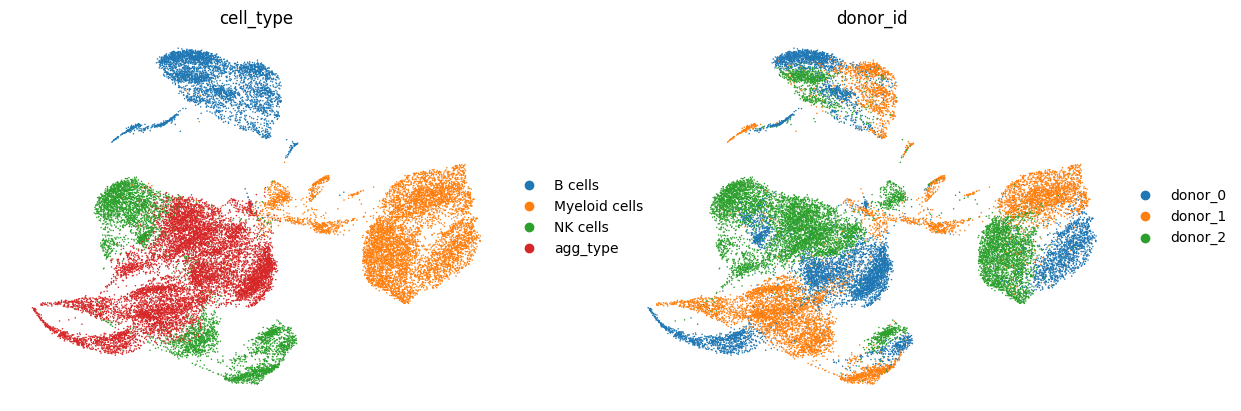

In [ ]:
sc.pl.umap(adata_rna, color=['cell_type', 'donor_id'], frameon=False)

As can be seen, the cell types of B cells and Myeloid cells are clearly seperated while there is more overlap between other cell types. We can also see the under represenation of T cells CD8+ and T regulatory cells. These two cell types are somewhat blended with T cells CD4+. We dont see any clear seggregation for donor_id.

In [ ]:
adata_rna.write(f'{work_dir}/scRNA/adata_rna.h5ad')

### Rank genes


In [ ]:
if 'obs' in adata_rna.uns:
    adata_rna.obs = adata_rna.uns['obs']
    sc.tl.rank_genes_groups(adata_rna, 'cell_type', method='t-test')
    sc.pl.rank_genes_groups(adata_rna, n_genes=25, sharey=False, ncols=2)  # Visualize top 25 genes

In [ ]:
adata_rna.uns['rank_genes_groups']['names']['B cells'][:5]

# scATAC-seq

### <a id='toc4_2_1_'></a>[Formatize the data](#toc0_)

In [ ]:
# extract only peaks
peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
del multiome_train

In [ ]:
if True: # all donors. 
    # extract only peaks
    peaks_locations = multiome_var_meta[multiome_var_meta['feature_type']=='Peaks']['location'].values
    df_peaks = multiome_train[multiome_train['location'].isin(peaks_locations)].reset_index(drop=True)
    # del multiome_train

    # make adata for each donor and save
    def extract_count(count='count'):
        df_peaks_table = df_peaks.pivot_table(index='obs_id', columns='location', values=count)
        df_peaks_table.fillna(0, inplace=True)
        print('df_peaks table created')
        return df_peaks_table
    df_peaks_table = extract_count(count='count')
    df_peaks_table_n = extract_count(count='normalized_count')
    # create adata
    X = csr_matrix(df_peaks_table.values)
    X_norm = csr_matrix(df_peaks_table_n.values)
    locations = df_peaks_table.columns
    obs_ids = df_peaks_table.index
    cell_types = []
    for cell in obs_ids:
        cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
    obs = pd.DataFrame(index=obs_ids)
    obs['cell_type'] = cell_types
    var = pd.DataFrame(index=locations)
    adata = anndata.AnnData(X=X, obs=obs, var=var, layers={'x_norm':X_norm})
    print('adata is created')
    # save
    adata.write(f'adata_atac.h5ad')
else: # each donor seperately
    # make adata for each donor and save
    donor_id = 'donor_2' # 0, 1, 2
    obs_ids_donor = multiome_obs_meta[multiome_obs_meta['donor_id']==donor_id]['obs_id'].values 
    df_peaks_donor = df_peaks[df_peaks['obs_id'].isin(obs_ids_donor)].reset_index(drop=True)
    def extract_count(count='count'):
        df_peaks_table = df_peaks_donor.pivot_table(index='obs_id', columns='location', values=count)
        df_peaks_table.fillna(0, inplace=True)
        print('df_peaks table created')
        return df_peaks_table
    df_peaks_table = extract_count(count='count')
    df_peaks_table_n = extract_count(count='normalized_count')
    # create adata
    X = csr_matrix(df_peaks_table.values)
    X_norm = csr_matrix(df_peaks_table_n.values)
    locations = df_peaks_table.columns
    obs_ids = df_peaks_table.index
    del df_peaks_donor
    cell_types = []
    for cell in obs_ids:
        cell_types.append(multiome_obs_meta[multiome_obs_meta['obs_id'] == cell].cell_type.values[0])
    obs = pd.DataFrame(index=obs_ids)
    obs['cell_type'] = cell_types
    var = pd.DataFrame(index=locations)
    adata = anndata.AnnData(X=X, obs=obs, var=var, layers={'x_norm':X_norm})
    print('adata is created')
    # save
    adata.write(ff'{work_dir}/scATAC/adata_{donor_id}.h5ad')
    print('adata saved')

In [ ]:
# add donor info
adata.obs = pd.merge(adata.obs, multiome_obs_meta[['obs_id', 'donor_id']], on='obs_id', how='left')


### <a id='toc4_2_2_'></a>[UMAP plot using scATAC-seq](#toc0_)
We use agg cell types for scenic+ only. For the remaining methods, we use individual cell types. We frist plot UMAP for all donors and individual cell types. Then, we plot the same graph for donor_0 and aggregated cell types.

In [ ]:
adata = anndata.read_h5ad(ff'{work_dir}/scATAC/adata_atac.h5ad')

In [ ]:
adata.X = adata.layers['x_norm']
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['cell_type', 'donor_id'], frameon=False)

In [ ]:
adata.X = adata.layers['counts']
# save
adata.write(ff'{work_dir}/scATAC/adata_atac.h5ad')
print('adata saved')

Similar to UMAP with the RNA data, We see two cell types of T cells CD8+ and T regulatory cells are somewhat blended with T cells CD4+.

## Merge cell types

In [ ]:
adata_atac = anndata.read_h5ad(ff'{work_dir}/scATAC/adata_atac.h5ad')
adata_rna = anndata.read_h5ad(ff'{work_dir}/scRNA/adata_rna.h5ad')

In [ ]:
adata_stack = [] 
for adata in [adata_rna, adata_atac]:
    # make it categorical
    adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
    # back up obs
    adata.uns['obs'] = adata.obs.copy()
    # agg cell type
    adata.obs.cell_type = adata.obs.cell_type.apply(lambda name: 'agg_type' if (name in agg_type) else name)

    adata_stack.append(adata)

adata_rna, adata_atac = adata_stack

In [ ]:
adata_atac.write_h5ad(ff'{work_dir}/scATAC/adata_atac.h5ad')
adata_rna.write_h5ad(ff'{work_dir}/scRNA/adata_rna.h5ad')